In [48]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor

# Cargar imagen
image_path = '../data/imgs/marbling.jpg'  # <- Cambiá esto por la ruta real
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Cargar modelo SAM
sam_checkpoint = "../checkpoints/sam_vit_h_4b8939.pth"  # <- Asegurate de tener este archivo
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)


In [49]:
clicked_points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        print(f"Click registrado en: ({x}, {y})")

cv2.imshow("Seleccionar carne y grasa", image)
cv2.setMouseCallback("Seleccionar carne y grasa", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(clicked_points) < 2:
    raise ValueError("Necesitás al menos 2 clics: uno en carne, otro en grasa.")



Click registrado en: (667, 748)
Click registrado en: (419, 436)


In [50]:
input_points = np.array(clicked_points[:2])  # Primer clic = carne, segundo = grasa
input_labels = np.array([1, 1])  # 1 = foreground

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True
)

# Elegimos las dos mejores máscaras (una por cada clic)
mask_carne = masks[0]
mask_grasa = masks[1]

# Asegurar que no se superpongan
mask_grasa = np.logical_and(mask_grasa, np.logical_not(mask_carne))


In [51]:
mask_multiclass = np.zeros_like(mask_carne, dtype=np.uint8)
mask_multiclass[mask_carne] = 1
mask_multiclass[mask_grasa] = 2


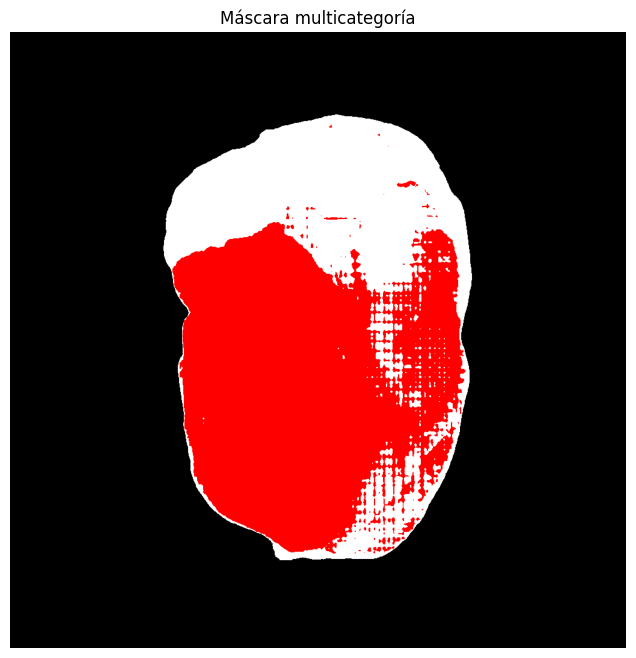

In [52]:
import matplotlib.pyplot as plt

colors = {
    0: [0, 0, 0],         # fondo - negro
    1: [255, 0, 0],       # carne - rojo
    2: [255, 255, 255]    # grasa - blanco
}

mask_rgb = np.zeros((*mask_multiclass.shape, 3), dtype=np.uint8)
for label, color in colors.items():
    mask_rgb[mask_multiclass == label] = color

plt.figure(figsize=(8, 8))
plt.imshow(mask_rgb)
plt.title("Máscara multicategoría")
plt.axis("off")
plt.show()


In [53]:
# --- Calcular porcentajes ---
total_pixels = np.count_nonzero(mask_multiclass)  # excluye fondo
carne_pixels = np.sum(mask_multiclass == 1)
grasa_pixels = np.sum(mask_multiclass == 2)

porcentaje_carne = carne_pixels / total_pixels * 100 if total_pixels > 0 else 0
porcentaje_grasa = grasa_pixels / total_pixels * 100 if total_pixels > 0 else 0

print(f"Porcentaje de carne: {porcentaje_carne:.2f}%")
print(f"Porcentaje de grasa: {porcentaje_grasa:.2f}%")

Porcentaje de carne: 60.44%
Porcentaje de grasa: 39.56%


In [ ]:
# Máscaras binarias
mask_carne = (mask_multiclass == 1).astype(np.uint8)
mask_grasa = (mask_multiclass == 2).astype(np.uint8)

# Guardar en formato .npy
np.save("data/imgs/masks/mascara_carne.npy", mask_carne)
np.save("data/imgs/masks/mascara_grasa.npy", mask_grasa)

print("Máscaras guardadas como .npy")


Máscaras guardadas como .npy
